In [1]:
import os
import shutil
import re
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
raw_dir = os.getenv("RAW")
nii_dir = os.getenv("NII")
print(raw_dir)

def moveRaw(raw_dir, nii_dir):
    """
    Function for converting files in the raw OAS directory to .nii, then moving them to the specified directory 'nii_dir'
    """
    i=0
    if not os.path.exists(nii_dir):
        os.makedirs(nii_dir)

    # Regex pattern to get the MRI id and visit number
    rawDirPat = r"(?:[\W\S]+?)OAS2_([0-9]{4})_MR([0-2]{1})/RAW"
    for root, dir, files in os.walk(raw_dir):
        r_match = re.findall(rawDirPat, root)
        if len(r_match) > 0:
            subID = r_match[0][0]
            session = r_match[0][1]
            new_name = f"{subID}_{session}"
            for f in files:
                # Get file extension
                fname, fext = os.path.splitext(f)
                # If the file is a .img, it should be converted to .nii
                if fext == ".img":
                    # Get mpr number from file name
                    f_match = re.findall(r"mpr-([0-2]{1}).nifti", fname)
                    if len(f_match) > 0:
                        f_num = f_match[0]

                        # Get full path of .img file
                        img_name = os.path.join(root, (fname + ".img"))

                        # Create new name for .nii file and put it in the right path
                        nii_name = os.path.join(
                            nii_dir, f"OAS2_{subID}_MR{session}_V{f_num}.nifti.nii"
                        )

                        # Load .img image using nibabel
                        img = nib.load(img_name)
                        # print(nii_name)

                        # Save .nii image in nii directory with new name
                        nib.save(img, nii_name)
                        print(f'{i:>4d}/1108 ({i*100./1108.:0>3.2f}%)')
                        # os.remove(os.path.join(root, fname + ".hdr"))
                        # os.remove(os.path.join(root, fname + ".img"))
                        i+=1



if os.getenv("MOVERAW")=="1":
    moveRaw(raw_dir, nii_dir)

datasets/OAS2


Move all files to one directory

In [3]:
from sklearn.model_selection import train_test_split

def makeTVTSplit(df):
  x_train, x_temp, y_train, y_temp = train_test_split(df.drop(columns=["Group"]), df["Group"], test_size=0.2, stratify=df[['Group',"Sex_F"]])

  strat = pd.DataFrame(x_temp)
  strat["Group"] = y_temp

  x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, stratify=strat[['Group',"Sex_F"]],test_size=0.4)
  train = x_train.copy(deep=True)
  train["Split"] = ["train"]*train.shape[0]
  train["Group"] = y_train.values

  validate = x_val.copy(deep=True)
  validate["Split"] = ["validate"]*validate.shape[0]
  validate["Group"] = y_val.values

  test = x_test.copy(deep=True)
  test["Split"] = ["test"]*test.shape[0]
  test["Group"] = y_test.values
  print(f"Split:")
  print(f'\tTest: {len(test)}')
  print(f'\tTrain: {len(train)}')
  print(f'\tValidate: {len(validate)}')

  df_new = pd.merge(train, test, how="outer")
  df_new = pd.merge(df_new, validate, how="outer")

  return df_new

df = pd.read_excel(os.getenv("OAS2NORM"))

if os.getenv("SPLITTVT") == "1":
  df_split = makeTVTSplit(df)
  df_split.to_excel("OAS2-split.xlsx")
else:
  df_split = pd.read_excel("OAS2-split.xlsx")

Split:
	Test: 35
	Train: 232
	Validate: 24


In [4]:
def getImgGroup(filename, df):

  filePattern = r"(OAS2_[0-9]{4}_MR[0-9]{1})"
  r_match = re.match(filePattern, filename)
  split = df[df["MRI ID"]==r_match.groups()[0]]["Group"].values
  if len(split) == 0:
     return -1
  else:
     return split[0]


In [5]:
def toRGB(data):
  """
  Function for converting a numpy array to the proper format to be saved as an RGB image.

  Parameters
  ---------
  data : numpy.ndarray
      Array of data to be converted to image
  """

  x, y = data.shape[:2]
  data = (data-data.min())/(data.max()-data.min())
  img_arr = np.empty(shape=(x,y,4))
  img_arr[:, :, :3] = data
  img_arr[:, :, 3] = 1.
  return img_arr

def cropImg(img_array):
   img_array = img_array[:240, :, :]
   return img_array



def getImgSplit(filename, split_df):

  filePattern = r"(OAS2_[0-9]{4}_MR[0-9]{1})"
  r_match = re.match(filePattern, filename)
  split = split_df[split_df["MRI ID"]==r_match.groups()[0]]["Split"].values
  if len(split) == 0:
     return -1
  else:
     return split[0]

def convertToJPG(nii_dir, jpg_dir, sliceStart,split_df, numImages=1):
    mult = 2
    i = 0
    shape = (0,0,0,0)
    if not os.path.exists(jpg_dir):
       os.makedirs(jpg_dir)

    for root, dir, files in os.walk(nii_dir):
        for f in files:
            fbase, fext = os.path.splitext(f)
            if fext == ".nii":
                i += 1
                fname = os.path.join(root, f)
                img = nib.load(fname)
                for i in range(numImages):
                  data = img.get_fdata()[sliceStart+i*mult,:,:]
                  img_arr = cropImg(toRGB(data))
                  shape = img_arr.shape
                  print(fbase)
                  split=getImgSplit(fbase, split_df)
                  group=getImgGroup(fbase, split_df)
                  if split!=-1 and group!=-1:
                    if split == 'test':
                      jpg_name = os.path.join(jpg_dir, split, f'{fbase.replace(".nifti","")}_{sliceStart+i*mult}.jpg')
                    else:
                       jpg_name = os.path.join(jpg_dir, split, f'class_{group}', f'{fbase.replace(".nifti","")}_{sliceStart+i*mult}.jpg')
                    plt.imsave(jpg_name, img_arr)

    return shape

jpg_dir = os.getenv("JPG")
if not os.path.exists(os.path.join(jpg_dir, "test")):
   os.makedirs(os.path.join(jpg_dir, "test"))

for split in ["validate", "train"]:
   if not os.path.exists(os.path.join(jpg_dir, split, "class_0")):
      os.makedirs(os.path.join(jpg_dir, split, "class_0"))
   if not os.path.exists(os.path.join(jpg_dir, split, "class_1")):
      os.makedirs(os.path.join(jpg_dir, split, "class_1"))


data_shape = (240, 110, 4)
if os.getenv("CONVERTJPG") == "1":
   data_shape = convertToJPG(nii_dir, jpg_dir, 80, df_split, int(os.getenv("NUMSLICES")))

OAS2_0055_MR2_V2.nifti
OAS2_0055_MR2_V2.nifti
OAS2_0055_MR2_V2.nifti
OAS2_0055_MR2_V2.nifti
OAS2_0139_MR2_V2.nifti
OAS2_0139_MR2_V2.nifti
OAS2_0139_MR2_V2.nifti
OAS2_0139_MR2_V2.nifti
OAS2_0124_MR2_V1.nifti
OAS2_0124_MR2_V1.nifti
OAS2_0124_MR2_V1.nifti
OAS2_0124_MR2_V1.nifti
OAS2_0091_MR1_V1.nifti
OAS2_0091_MR1_V1.nifti
OAS2_0091_MR1_V1.nifti
OAS2_0091_MR1_V1.nifti
OAS2_0040_MR1_V1.nifti
OAS2_0040_MR1_V1.nifti
OAS2_0040_MR1_V1.nifti
OAS2_0040_MR1_V1.nifti
OAS2_0159_MR1_V2.nifti
OAS2_0159_MR1_V2.nifti
OAS2_0159_MR1_V2.nifti
OAS2_0159_MR1_V2.nifti
OAS2_0146_MR2_V1.nifti
OAS2_0146_MR2_V1.nifti
OAS2_0146_MR2_V1.nifti
OAS2_0146_MR2_V1.nifti
OAS2_0139_MR2_V1.nifti
OAS2_0139_MR2_V1.nifti
OAS2_0139_MR2_V1.nifti
OAS2_0139_MR2_V1.nifti
OAS2_0152_MR2_V1.nifti
OAS2_0152_MR2_V1.nifti
OAS2_0152_MR2_V1.nifti
OAS2_0152_MR2_V1.nifti
OAS2_0087_MR1_V2.nifti
OAS2_0087_MR1_V2.nifti
OAS2_0087_MR1_V2.nifti
OAS2_0087_MR1_V2.nifti
OAS2_0052_MR2_V1.nifti
OAS2_0052_MR2_V1.nifti
OAS2_0052_MR2_V1.nifti
OAS2_0052_M

# Model

In [6]:
import keras
from keras import layers
from keras import ops
from keras import Sequential
import tensorflow as tf
import SimpleITK as sitk


2025-04-09 18:05:33.614788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 18:05:33.623325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744243533.633787  513249 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744243533.636918  513249 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744243533.644716  513249 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
resnet_base = keras.applications.ResNet50(
  include_top=False,
  weights='imagenet',
  input_shape=(data_shape[0], data_shape[1], 3)
)

resnet_base.trainable = False

model = Sequential([
  resnet_base,
  layers.Flatten(),
  layers.Dense(1856, activation='relu'),
  layers.Dense(426, activation='leaky_relu'),
  layers.Dense(116, activation='relu'),
  layers.Dense(2, activation='softmax')
])

model.compile(
  optimizer=keras.optimizers.Adam(),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)


I0000 00:00:1744243534.864993  513249 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7810 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
def makeKerasTVTDatasets(batchSize):

  dset_train = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(os.getenv("JPG"),"train"),
    seed=73,
    image_size=data_shape[:2],
    batch_size=batchSize,
    label_mode='binary')

  dset_validate = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(os.getenv("JPG"),"validate"),
    seed=73,
    image_size=data_shape[:2],
    batch_size=batchSize,
    label_mode='binary')

  return dset_train, dset_validate

dset_train, dset_validate = makeKerasTVTDatasets(16)

Found 2120 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [10]:
if os.getenv("TRAINMODEL") == "1":
  history = model.fit(dset_train, validation_data=dset_validate, epochs=25)



  if os.getenv("SAVEMODEL") == "1":
    # Save the model
    model.save("oas2-model.keras")


Epoch 1/25


I0000 00:00:1744243540.003080  513358 service.cc:152] XLA service 0x7fefc0002fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744243540.003096  513358 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-09 18:05:40.104387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744243540.993934  513358 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-09 18:05:41.912277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5015', 232 bytes spill stores, 232 bytes spill loads

2025-04-09 18:05:41.913282: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_501

  7/133 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5119 - loss: 62.5174

I0000 00:00:1744243545.909443  513358 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/133 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5897 - loss: 22.9836

2025-04-09 18:05:50.119958: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5015', 216 bytes spill stores, 216 bytes spill loads

2025-04-09 18:05:50.164393: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5015', 340 bytes spill stores, 340 bytes spill loads

2025-04-09 18:05:50.271839: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7841', 12 bytes spill stores, 12 bytes spill loads

2025-04-09 18:05:50.292294: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5015', 156 bytes spill stores, 156 bytes spill loads

2025-04-09 18:05:50.321455: I exte

133/133 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5926 - loss: 22.5655 - val_accuracy: 0.7070 - val_loss: 1.0477
Epoch 2/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9071 - loss: 0.2272 - val_accuracy: 0.8867 - val_loss: 0.4465
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9903 - loss: 0.0288 - val_accuracy: 0.9102 - val_loss: 0.4432
Epoch 4/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9991 - loss: 0.0091 - val_accuracy: 0.9180 - val_loss: 0.3866
Epoch 5/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9180 - val_loss: 0.4026
Epoch 6/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 5.1613e-04 - val_accuracy: 0.9180 - val_loss: 0.4209
Epoch 7/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 3.7626e-04 - val_accuracy: 0.9180 - val_loss: 0.4391
Epoch 8/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 2.8898e-04 - val_a

In [11]:
df_h = pd.DataFrame({"Epoch":np.arange(1, 26, 1), "Validation_accuracy":history.history['val_accuracy'],"Training_accuracy":history.history['accuracy']})
df_h.to_excel("Training-validation-data.xlsx")

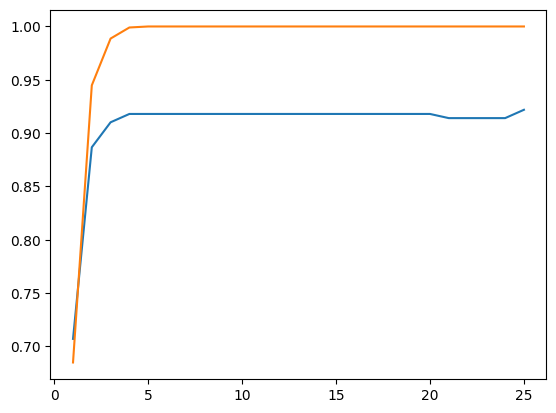

In [12]:
plt.plot(df_h["Epoch"],df_h["Validation_accuracy"])
plt.plot(df_h["Epoch"],df_h["Training_accuracy"])

In [13]:
predictions = []
fileList = []
mriID = []
groups = []
df_old = df.copy(deep=True)

i = 0
for root, dir, files in os.walk(os.path.join(os.getenv("JPG"), "test")):
  for f in files:
    g = getImgGroup(f, df)
    img = keras.preprocessing.image.load_img(os.path.join(root, f), target_size=data_shape[:2])
    img_arr = keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)
    groups += [g]
    mriID += [f[:13]]
    fileList += [f]
    predictions += [np.argmax(model.predict(img_arr))]
    print(i,'\n')
    i += 1

df_predictions = pd.DataFrame({"MRI ID": mriID, "Group": groups, "Prediction": predictions, "File": fileList})


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
10 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
11 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
12 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
14 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
16 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
17 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
18 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
19 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
20 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
21 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
22 

1/1 ━━━━━━━━━━━━━━━━━━━

In [14]:
# df_predictions = pd.merge(df_predictions, df.copy(deep=True), how="outer")

print(df.shape)

tf_a = []
for index, row in df_predictions.iterrows():
  p = row["Prediction"]
  g = row["Group"]
  tf_a += [1 if g == p else 0]

df_predictions["TF"] = tf_a

df_predictions.to_excel(os.getenv("PREDICTIONS"), index=False)

(291, 13)
